In [8]:
# %%
from kan import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdb


In [9]:
# %%
import math
from torch.utils.data import Dataset

# f = lambda x: (x[:,[0]]**2 + x[:,[2]] + 3*torch.sin(x[:,[1]]))/(x[:,[0]] + 2*x[:,[1]] - x[:,[2]])
# sin(x) * cos(y) + exp(z/2) - x^2 * y
f = lambda x: torch.sin(x[:, [0]]) * torch.cos(x[:, [1]]) + torch.exp(x[:, [2]]/2) - x[:, [0]]**2 * x[:, [1]]
datasetall = create_dataset(f, n_var=3, train_num=20000, test_num=4000, seed=0, ranges=[[-5, 5], [-5, 5], [-5, 5]])
datasetoct0 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[-5, 0], [-5, 0], [-5, 0]])


 ## build KAN architecture

 Training KAN

In [10]:
# %%
# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

# model = KAN(width=[3,5,1], grid=5, k=3, noise_scale=0.1, bias_trainable=False, sp_trainable=False, sb_trainable=False, device="cpu")
model = KAN(width=[3,5,1], grid=5, k=3, noise_scale=0.1, device="cpu")
# model.train(dataset, opt = 'Adam', steps=2000, update_grid=False, device="cuda", lr=0.5e-3)
model.train(datasetoct0, opt="LBFGS", steps=80);

train loss: 3.63e-02 | test loss: 4.08e-02 | reg: 1.96e+01 : 100%|██| 80/80 [00:31<00:00,  2.54it/s]


 Prediction of KAN after each stage

In [15]:
f_pred = model(datasetoct0['test_input']).to('cpu').detach().numpy()

In [16]:
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()

In [17]:
# compute R^2 between prediction and true value
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

R^2: 0.9999982755051633


### now prune network

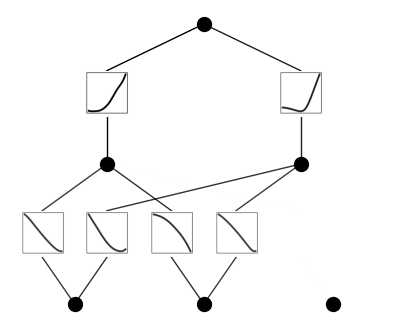

In [18]:
model = model.prune(threshold=0.1)
model(datasetoct0['train_input'].to("cpu"))
model.plot()

## retrain network using such model and see

In [19]:
model.train(datasetoct0, opt="LBFGS", steps=80);
f_pred = model(datasetoct0['test_input']).to('cpu').detach().numpy()
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

train loss: 1.12e-01 | test loss: 1.02e-01 | reg: 1.14e+01 : 100%|██| 80/80 [00:19<00:00,  4.12it/s]

R^2: 0.9999892189089223


## looks good, as R^2 > 0.95. We will use the network for the next dataset

In [20]:
datasetoct1 = create_dataset(f, n_var=3, train_num=2500, test_num=500, seed=0, ranges=[[-5, 0], [-5, 0], [0, 5]])

### freeze/slow down/regularize network and determine nodes that is the opposite of pruning